In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [3]:
import xarray as xr
from scipy.interpolate import RectBivariateSpline, griddata

In [4]:
import utm

In [5]:
from stl import mesh  # install with `pip install numpy-stl`

In [6]:
from mmctools.coupling.terrain import SRTM

# Terrain-Resolved Domain Setup
This notebook will generate a surface geometry file to be used by the microscale solver (e.g., SOWFA) to conform the solver domain to the terrain (e.g., with `moveDynamicMesh`).

Notebook written by Eliot Quon, modified by Regis Thedin\
{eliot.quon,regis.thedin}@nrel.gov

## 1. User input

In [7]:
# Output directory (absolute dir)
outdir = '/home/rthedin/stl'

### 1.1 Mesoscale parameters

In [8]:
# Get lower resolution WRF terrain data
getWRFdata = False
# WRF reference solution to blend from low-res (WRF) at inflow boundaries to full SRTM resolution
wrfout = '/home/rthedin/MMC/WFIP2Region/20161121_YSU/wrfout_d01_2016-11-22_00:00:00'

### 1.2 Microscale parameters


First, set the resolution of the data the STL will be created from, and the output resolution.

In [9]:
product = 'SRTM1' # SRTM1 | SRTM3 (30- and 90-m DEM)
ds = 10. # output resolution

The following cell should be modified by the user, following the examples given. The cell contains information about the actual location to be saved.

The `refloc` variable is the location coresponding to (0,0) in SOWFA.

Set the fringe on each side of the domain. This fringe region will used to blend the high-resolution SRTM domain data with either i) low-reosolution WRF (mesoscale) digital elevation model (DEM), or ii) flat.

If `getWRFdata` above is `True`, then blending to mesoscale will occur; otherwise, the domain will be blended to flat. If blending to flat, the user can specify an extra fringe region of completely flat domain (`fringe_flat`). Additionally, if blending to flat, the terrain surface data can be shifted vertically such that the flat region is at $z=0$ by setting `shiftFlatToZero` to `True`.

With respect to the bounding box, it is nice to have the boundaries exactly where the mesh would go because of the blending. For instance, a 5x5 km domain needs to match all the levels of cells: 20, 40, 80, 160 m. Essentially, 5000/160 needs to be an integer number, the same way 5000/80 needs to be as well. However, we only really need to match the coarsest resolution because they are multiple. Finally, an extra fringe of width `ds` (the resolution set above) is added, half on each side. The desired bounding box should go into the `xmin`,`xmax`,`ymin`,`ymax` variables, ignoring the `ds` addition. This extra fringe is to ensure that the STL is slighly larger than the bounding box that will be set on the microscale solver (needed in OpenFOAM to avoid numerical issues).

In [10]:
# # For TOTW. Fits both 20/40/80/160 and 30/60/120/240m grids (30m is the resolution from SRTM1)
# refloc = (42.944092, -105.773689, 500) # TOTW turbine 3032051 location
# xmin,xmax = -25000-ds/2, 5240+ds/2
# ymin,ymax = -7000-ds/2,  13160+ds/2
# fringe_flat=100
# shiftFlatToZero=True
# fringe_s = 2000
# fringe_n = 2000
# fringe_w = 4000
# fringe_e = 2000
# case = f'totw_xm{abs(int(xmin))}to{int(xmax)}_ym{abs(int(ymin))}to{int(ymax)}_blendFlat2N2S2E4W_ff{fringe_flat}'


# For TOTW. Large 50x50 km bounding box. Fits both 20/40/80/160 and 30/60/120/240m grids
# Rimple's origin
refloc = (42.790035, -106.1757, 500)
xmin,xmax = 0-ds/2, 49920+ds/2
ymin,ymax = 0-ds/2, 49920+ds/2
# My origin
refloc = (42.944092, -105.773689, 500) # TOTW turbine 3032051 location
#xmin, xmax = -33036.15111739, 16963.88553768   # These are the 50x50 with exactly his bounding box
#ymin, ymax = -16727.49228685, 33272.53479028    # Modified slightly to accomodate a multiple of 480
xmin, xmax = -33035-ds/2, 16885+ds/2
ymin, ymax = -16725-ds/2, 33195+ds/2
fringe_flat=100
shiftFlatToZero=True
fringe_s = 3000
fringe_n = 3000
fringe_w = 3000
fringe_e = 3000
case = f'totw_xm{abs(int(xmin))}to{int(xmax)}_ym{abs(int(ymin))}to{int(ymax)}_blendFlat3N3S3E3W_ff{fringe_flat}'


# # For WFIP2 region
# # - blend to flat
# refloc = (45.638004, -120.642973, 495) # biglow PS12 met mast
# xmin,xmax = -15000-ds/2, 15720+ds/2
# ymin,ymax = -5000-ds/2, 15160+ds/2
# fringe_flat=150
# shiftFlatToZero=True
# fringe_w = 3000
# fringe_s = 3000
# fringe_n = 3000
# fringe_e = 3000
# case = f'wfip_xm{abs(int(xmin))}to{int(xmax)}_ym{abs(int(ymin))}to{int(ymax)}_blendFlat3N3S3E3W_ff{fringe_flat}'
# # - blend to WRF
# refloc = (45.638004, -120.642973, 495) # biglow PS12 met mast
# xmin,xmax = -15000-ds/2, 15720+ds/2
# ymin,ymax = -5000-ds/2, 15160+ds/2
# fringe_flat=0
# shiftFlatToZero=False
# fringe_w = 3000
# fringe_s = 3000
# fringe_n = 3000
# fringe_e = 3000
# case = f'wfip_xm{abs(int(xmin))}to{int(xmax)}_ym{abs(int(ymin))}to{int(ymax)}_blendWRF3N3S3E3W'

In [11]:
# For TOTW. Medium-sized 30x20 km bounding box. Fits both 20/40/80/160 and 30/60/120/240m grids
# Rimple's origin
refloc = (42.790035, -106.1757, 500)
xmin,xmax = 0-ds/2, 29760+ds/2
ymin,ymax = 0-ds/2, 20160+ds/2
# My origin
refloc = (42.944092, -105.773689, 500) # TOTW turbine 3032051 location
xmin, xmax = -22935-ds/2, 6825+ds/2
ymin, ymax = -7525-ds/2, 12635+ds/2
fringe_flat=100
shiftFlatToZero=True
fringe_s = 2000
fringe_n = 2000
fringe_w = 2000
fringe_e = 2000
case = f'totw_xm{abs(int(xmin))}to{int(xmax)}_ym{abs(int(ymin))}to{int(ymax)}_blendFlat2N2S2E2W_ff{fringe_flat}'

In [116]:
# # For WFIP (Biglow). Small domain (3x3) for testing purposes. Fits both 20/40/80/160 and 30/60/120/240m grids
# # Rimple's origin
# refloc = (45.638004, -120.642973, 495) # biglow PS12 met mast
# xmin,xmax = 0-ds/2, 3000+ds/2
# ymin,ymax = 0-ds/2, 3000+ds/2
# fringe_flat=100
# shiftFlatToZero=True
# fringe_w = 500
# fringe_s = 500
# fringe_n = 500
# fringe_e = 500
# case = f'wfip_xm{abs(int(xmin))}to{int(xmax)}_ym{abs(int(ymin))}to{int(ymax)}_blendFlat0p5N0p5S0p5E0p5W_ff{fringe_flat}'



In [10]:
# For TOTW. Very large to see effects of Casper Mountain. Not for actual use
# My origin
refloc = (42.944092, -105.773689, 500) # TOTW turbine 3032051 location
xmin, xmax = -33035-ds/2, 16885+ds/2
ymin, ymax = -16725-ds/2, 33195+ds/2
fringe_flat=100
shiftFlatToZero=True
fringe_s = 300
fringe_n = 300
fringe_w = 300
fringe_e = 300
case = f'temp'


In [57]:
# For TOTW. 5x5 plus fringes of 500m on all sides. Fits 10/20/40/80/160m grids
# My origin
refloc = (42.944092, -105.773689, 500) # TOTW turbine 3032051 location
xmin, xmax = -3500-ds/2, 2580+ds/2
ymin, ymax = -500-ds/2, 5580+ds/2
fringe_flat=80
shiftFlatToZero=True
fringe_s = 500
fringe_n = 500
fringe_w = 500
fringe_e = 500
case = f'totw_xm{abs(int(xmin))}to{int(xmax)}_ym{abs(int(ymin))}to{int(ymax)}_blendFlat0p5N0p5S05E0p5W_ff{fringe_flat}'

## 2. Create output surface

In [58]:
x1 = np.arange(xmin, xmax+ds, ds)
y1 = np.arange(ymin, ymax+ds, ds)
xsurf,ysurf = np.meshgrid(x1, y1, indexing='ij')

In [59]:
print('The output bounding box is')
print('xmin: ',xsurf[0,0], '\nxmax: ',xsurf[-1,-1])
print('ymin: ',ysurf[0,0], '\nymax: ',ysurf[-1,-1])

The output bounding box is
xmin:  -3505.0 
xmax:  2585.0
ymin:  -505.0 
ymax:  5585.0


## 3. Get the high-resolution terrain

In [60]:
# Terrain region to clip from the digital elevation model (DEM)
srtm_bounds = west, south, east, north = (refloc[1]-0.9, refloc[0]-0.6, refloc[1]+0.62, refloc[0]+0.42)

# this will be downloaded:
srtm_output=f'{outdir}/{case}.tif' # need absolute path for GDAL

In [61]:
srtm = SRTM(srtm_bounds, fpath=srtm_output, product=product)

In [62]:
%time srtm.download()
# CPU times: user 3.53 ms, sys: 12.7 ms, total: 16.2 ms
# Wall time: 8.74 s

CPU times: user 3.78 ms, sys: 489 ms, total: 493 ms
Wall time: 54.2 s


In [63]:
%%time
# original SRTM terrain stored as 'z'
x,y,z = srtm.to_terrain()

Output grid at ds= 30.0
Projecting from EPSG:4326 to EPSG:32613
CPU times: user 4.51 s, sys: 691 ms, total: 5.2 s
Wall time: 5.21 s


In [64]:
# get reference location to use as origin
xref,yref,_,_ = utm.from_latlon(*refloc[:2], force_zone_number=srtm.zone_number)

<ipython-input-65-d86e5a13e472>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cm = ax.pcolormesh(x-xref, y-yref, z, cmap='terrain',vmin=1400,vmax=2500)


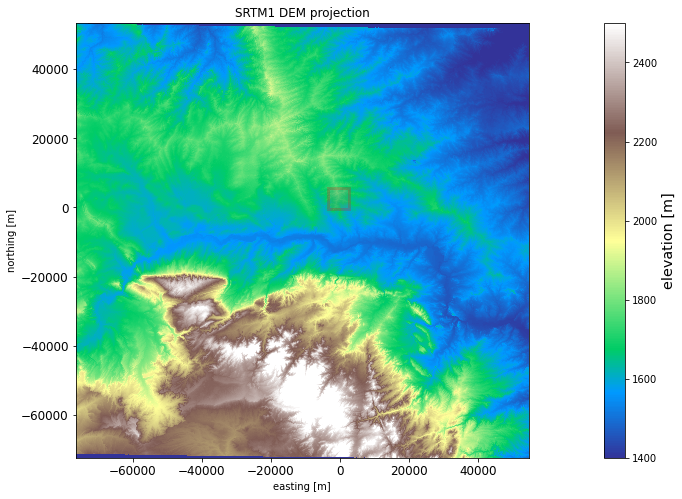

In [65]:
vmin,vmax = 1500,2500

fig,ax = plt.subplots(figsize=(12,8))
cm = ax.pcolormesh(x-xref, y-yref, z, cmap='terrain',vmin=1400,vmax=2500)
cb = fig.colorbar(cm,ax=ax)
cb.set_label('elevation [m]',fontsize='x-large')
ax.tick_params(labelsize='large')
ax.set_xlabel('easting [m]')
ax.set_ylabel('northing [m]')
ax.set_title(f'{product} DEM projection')
ax.axis('scaled')

# too see casper mountain:
# ax.set_xlim([-70000, 18000])
# ax.set_ylim([-50000, 35000])

# bounding box for microscale region
les = Rectangle((xmin,ymin), xmax-xmin, ymax-ymin, edgecolor='r', lw=3, facecolor='0.5', alpha=0.2)
ax.add_patch(les)

<ipython-input-66-d74e91819736>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cm = ax.pcolormesh(x-xref, y-yref, z, cmap='terrain')#,vmin=vmin,vmax=vmax)


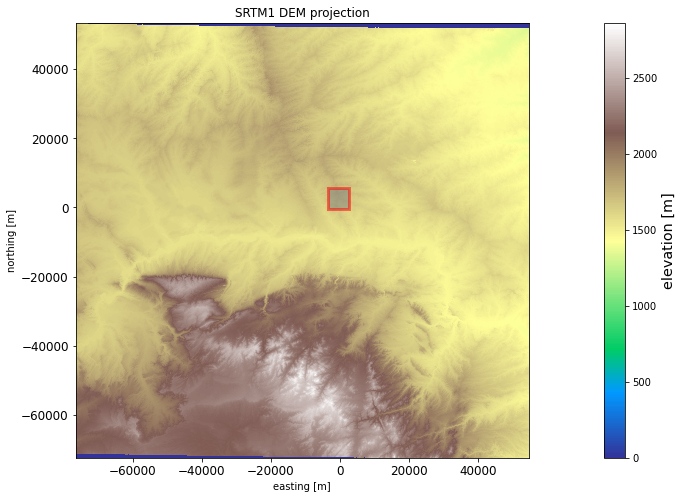

In [66]:
vmin,vmax = 1500,2500

fig,ax = plt.subplots(figsize=(12,8))
cm = ax.pcolormesh(x-xref, y-yref, z, cmap='terrain')#,vmin=vmin,vmax=vmax)
cb = fig.colorbar(cm,ax=ax)
cb.set_label('elevation [m]',fontsize='x-large')
ax.tick_params(labelsize='large')
ax.set_xlabel('easting [m]')
ax.set_ylabel('northing [m]')
ax.set_title(f'{product} DEM projection')
ax.axis('scaled')

# bounding box for microscale region
les = Rectangle((xmin,ymin), xmax-xmin, ymax-ymin, edgecolor='r', lw=3, facecolor='0.5', alpha=0.5)
ax.add_patch(les)

### 3.1 Downscale to output grid

In [67]:
interpfun = RectBivariateSpline(x[:,0]-xref, y[0,:]-yref, z)

In [68]:
# resampled SRTM data stored in 'zsrtm'
zsrtm = interpfun(x1,y1,grid=True)

<ipython-input-69-261f2b21e7f2>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cm = ax.pcolormesh(xsurf, ysurf, zsrtm, cmap='terrain')#,vmin=vmin,vmax=vmax)


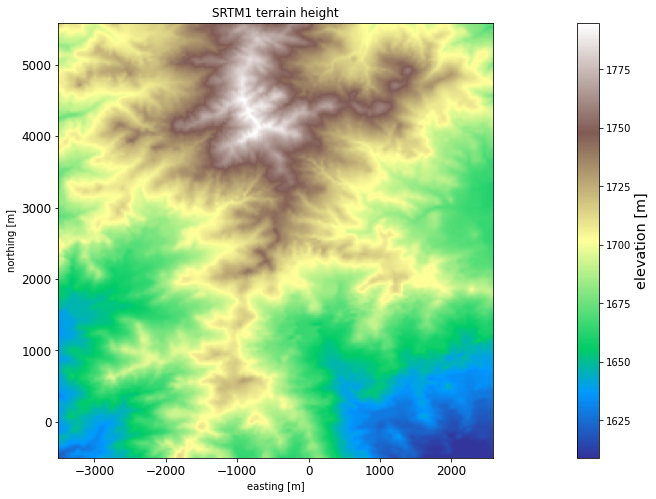

In [69]:
fig,ax = plt.subplots(figsize=(12,8))
cm = ax.pcolormesh(xsurf, ysurf, zsrtm, cmap='terrain')#,vmin=vmin,vmax=vmax)
cb = fig.colorbar(cm,ax=ax)
cb.set_label('elevation [m]',fontsize='x-large')
ax.tick_params(labelsize='large')
ax.set_xlabel('easting [m]')
ax.set_ylabel('northing [m]')
ax.set_title(f'{product} terrain height')
ax.axis('scaled')

fig.savefig(f'{outdir}/{case}_elevation_srtm.png',dpi=150,bbox_inches='tight')

## 4. Get the low-resolution terrain from the mesoscale
This part is only relevant if the user chose to blen the high-resolution SRTM terrain data with WRF

In [70]:
# Open the dataset
if getWRFdata is True:
    if os.path.isfile(wrfout) is True:
        wrf = xr.open_dataset(wrfout)
        wrf['HGT']
    else:
        print('WRF input does not exist')
        sys.exit(1)

In [71]:
if getWRFdata is True:
    # wrf fields
    hgt = wrf['HGT'][0,:,:]
    xlat = wrf.coords['XLAT'][0,:,:]
    xlon = wrf.coords['XLONG'][0,:,:]

In [72]:
if getWRFdata is True:
    %time output_lat, output_lon = srtm.to_latlon(xsurf.ravel()+xref, ysurf.ravel()+yref)
    # CPU times: user 3.38 s, sys: 157 ms, total: 3.54 s
    # Wall time: 3.54 s

In [73]:
if getWRFdata is True:
    # interpolate to wrf surface elevation based on lat/lon (stored as 'zwrf')
    xi = np.stack((output_lat.ravel(),output_lon.ravel()),axis=-1)
    points = np.stack((xlat.values.ravel(),xlon.values.ravel()),axis=-1)
    values = hgt.values.ravel()
    zi = griddata(points,values,xi)
    zwrf = zi.reshape(xsurf.shape)
    # CPU times: user 3.14 s, sys: 931 ms, total: 4.07 s
    # Wall time: 2.57 s

In [74]:
if getWRFdata is True:
    fig,ax = plt.subplots(figsize=(12,8))
    cm = ax.pcolormesh(xsurf, ysurf, zwrf, cmap='terrain')#,vmin=vmin,vmax=vmax)
    cb = fig.colorbar(cm,ax=ax)
    cb.set_label('elevation [m]',fontsize='x-large')
    ax.tick_params(labelsize='large')
    ax.set_xlabel('easting [m]')
    ax.set_ylabel('northing [m]')
    ax.set_title('WRF terrain height')
    ax.axis('scaled')

    fig.savefig(f'{os.path.basename(wrfout)}_elevation_wrf.png',dpi=150,bbox_inches='tight')

## 5. Blend surface definitions

In [75]:
# check distance from west boundary
blend_w = np.ones(xsurf.shape)
if fringe_w > 0:
    blend_w = np.minimum(np.maximum((xsurf-xmin-fringe_flat)/fringe_w, 0), 1)

In [76]:
# check distance from east boundary
blend_e = np.ones(xsurf.shape)
if fringe_e > 0:
    blend_e = np.minimum(np.maximum((xmax-xsurf-fringe_flat)/fringe_e, 0), 1)

In [77]:
# check distance from south boundary
blend_s = np.ones(xsurf.shape)
if fringe_s > 0:
    blend_s = np.minimum(np.maximum((ysurf-ymin-fringe_flat)/fringe_s, 0), 1)

In [78]:
# check distance from north boundary
blend_n = np.ones(xsurf.shape)
if fringe_n > 0:
    blend_n = np.minimum(np.maximum((ymax-ysurf-fringe_flat)/fringe_n, 0), 1)

In [79]:
# combine blending functions
blend = blend_w * blend_e * blend_s * blend_n

<ipython-input-80-0f42c430c3d1>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cm = ax.pcolormesh(xsurf, ysurf, blend, cmap='magma')


(-3505.0, 2585.0, -505.0, 5585.0)

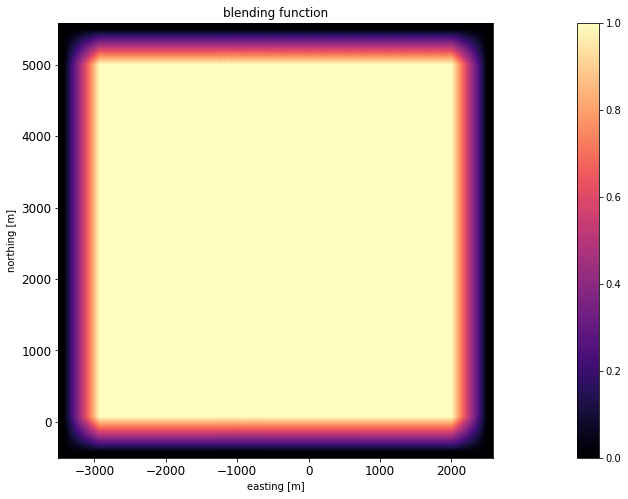

In [80]:
fig,ax = plt.subplots(figsize=(12,8))
cm = ax.pcolormesh(xsurf, ysurf, blend, cmap='magma')
cb = fig.colorbar(cm,ax=ax)
ax.tick_params(labelsize='large')
ax.set_xlabel('easting [m]')
ax.set_ylabel('northing [m]')
ax.set_title('blending function')
ax.axis('scaled')

In [81]:
# create flat surface to be blended
# SRTM data is unlikely to be around the z=0 mark, so get the average 
z0 = np.mean(zsrtm)
zflat = np.full(zsrtm.shape,z0)

In [82]:
# surface to blend
if getWRFdata is True:
    zlowres = zwrf
else:
    zlowres = zflat

In [83]:
# now, blend the high/low resolution elevations
zblend = blend*zsrtm + (1-blend)*zlowres

<ipython-input-84-26c0a2450c29>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cm = ax.pcolormesh(xsurf, ysurf, zblend, cmap='terrain')#,vmin=vmin,vmax=vmax)


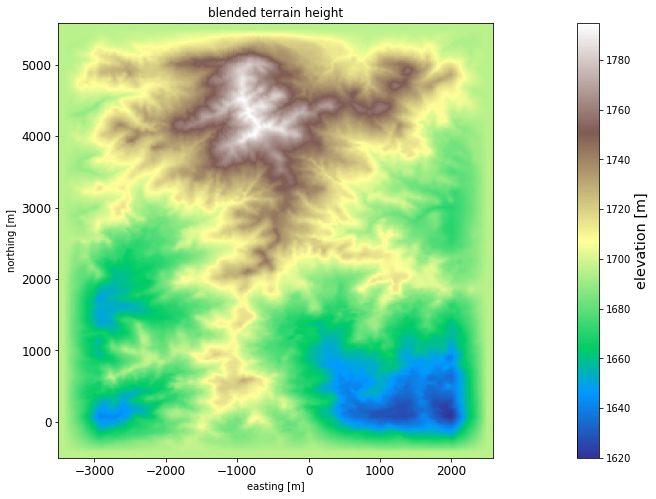

In [84]:
fig,ax = plt.subplots(figsize=(12,8))
cm = ax.pcolormesh(xsurf, ysurf, zblend, cmap='terrain')#,vmin=vmin,vmax=vmax)
cb = fig.colorbar(cm,ax=ax)
cb.set_label('elevation [m]',fontsize='x-large')
ax.tick_params(labelsize='large')
ax.set_xlabel('easting [m]')
ax.set_ylabel('northing [m]')
ax.set_title('blended terrain height')
ax.axis('scaled')
fig.savefig(f'{outdir}/{case}_elevation_blended.png',dpi=150,bbox_inches='tight')

# 6. Shift terrain
Shifts the terrain data so that the flat borders are at $z=0$

In [85]:
if shiftFlatToZero:
    zblend = zblend - zblend[0,0]
    case = case + '_shiftFlat'

<ipython-input-86-868b017fb058>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cm = ax.pcolormesh(xsurf, ysurf, zblend, cmap='terrain')#,vmin=vmin,vmax=vmax)


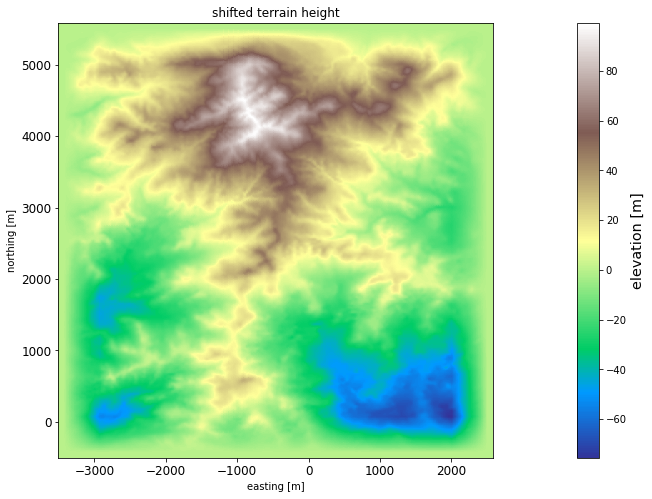

In [86]:
if shiftFlatToZero:
    fig,ax = plt.subplots(figsize=(12,8))
    cm = ax.pcolormesh(xsurf, ysurf, zblend, cmap='terrain')#,vmin=vmin,vmax=vmax)
    cb = fig.colorbar(cm,ax=ax)
    cb.set_label('elevation [m]',fontsize='x-large')
    ax.tick_params(labelsize='large')
    ax.set_xlabel('easting [m]')
    ax.set_ylabel('northing [m]')
    ax.set_title('shifted terrain height')
    ax.axis('scaled')
    fig.savefig(f'{outdir}/{case}_elevation_blended.png',dpi=150,bbox_inches='tight')

In [87]:
# Save the zblend array for sampling the height later
np.save(f'{outdir}/{case}_zstl.npy',zblend)

## 6. Write out terrain surface STL

In [88]:
stlout = f'{outdir}/{case}.stl'

In [89]:
# output 'zblend' surface - can skip blending step and just output 'zsrtm'
Npts = np.prod(xsurf.shape)
stlpoints = np.stack((xsurf.ravel(),
                      ysurf.ravel(),
                     zblend.ravel()),  # <-- output surface here
                    axis=-1)

stlindices = np.reshape(np.arange(Npts), xsurf.shape)

In [90]:
%%time
Nx,Ny = xsurf.shape
Nfaces = (Nx-1)*(Ny-1)*2

surf = mesh.Mesh(np.zeros(Nfaces, dtype=mesh.Mesh.dtype))

#
# manually define triangular faces for this simple quad mesh
#
# for iface, f in enumerate(faces):
#     for dim in range(3):
#         surf.vectors[iface][dim] = vertices[f[dim],:]
iface = 0 
for i in range(Nx-1):
    for j in range(Ny-1):
        surf.vectors[iface,0,:] = stlpoints[stlindices[i,j],:]
        surf.vectors[iface,1,:] = stlpoints[stlindices[i+1,j],:]
        surf.vectors[iface,2,:] = stlpoints[stlindices[i+1,j+1],:]
        surf.vectors[iface+1,0,:] = stlpoints[stlindices[i+1,j+1],:]
        surf.vectors[iface+1,1,:] = stlpoints[stlindices[i,j+1],:]
        surf.vectors[iface+1,2,:] = stlpoints[stlindices[i,j],:]
        iface += 2
assert (iface == Nfaces)
# CPU times: user 27.5 s, sys: 182 ms, total: 27.7 s
# Wall time: 27.7 s

CPU times: user 2.83 s, sys: 36.7 ms, total: 2.87 s
Wall time: 2.88 s


In [91]:
dpath = os.path.dirname(stlout)
if (not dpath == '') and (not os.path.isdir(dpath)):
    os.makedirs(dpath)
    print('Created',dpath)
    
surf.save(stlout)
# surf.save(stlout, mode=mesh.stl.ASCII) # if ASCII STL is needed
print('Saved',stlout)

Saved /home/rthedin/stl/totw_xm3505to2585_ym505to5585_blendFlat0p5N0p5S05E0p5W_ff80_shiftFlat.stl


In [92]:
a=1